# Lesson 7: Case Studies

## Load AWS API Keys

Put keys in local or remote GDrive:  

`cp ~/.aws/credentials /Users/myname/Google\ Drive/awsml/`

### Mount GDrive


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
import os;os.listdir("/content/gdrive/My Drive/awsml")

['kaggle.json', 'credentials', 'config']

### Install Boto

In [0]:
!pip -q install boto3


### Create API Config

In [0]:
!mkdir -p ~/.aws &&\
  cp /content/gdrive/My\ Drive/awsml/credentials ~/.aws/credentials 

### Test Comprehend API Call

In [0]:
import boto3
comprehend = boto3.client(service_name='comprehend', region_name="us-east-1")
text = "There is smoke in San Francisco"
comprehend.detect_sentiment(Text=text, LanguageCode='en')

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '160',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 14 Dec 2018 16:11:55 GMT',
   'x-amzn-requestid': 'fa00db36-ffba-11e8-882b-8bc33ca9084d'},
  'HTTPStatusCode': 200,
  'RequestId': 'fa00db36-ffba-11e8-882b-8bc33ca9084d',
  'RetryAttempts': 0},
 'Sentiment': 'NEUTRAL',
 'SentimentScore': {'Mixed': 0.008628507144749165,
  'Negative': 0.1037612184882164,
  'Neutral': 0.8582549691200256,
  'Positive': 0.0293553676456213}}

## 7.1 Sagemaker Features

### Search

#### [Demo] Search

[Manage Machine Learning Experiments with Search](https://docs.aws.amazon.com/sagemaker/latest/dg/search.html)



*   Finding training jobs
*   Rank training jobs
*   Tracing lineage of a model



### Ground Truth

![ground_truth](https://user-images.githubusercontent.com/58792/49688683-9bdba100-faca-11e8-8d93-a55ce6c35a92.png)



*   Setup and Manage labeling jobs
*   Uses active learning and human labeling
*   First 500 objects labeled per month are free



#### [Demo] Labeling Job

### Notebook

![notebooks](https://user-images.githubusercontent.com/58792/49688694-d04f5d00-faca-11e8-9fad-eb63b2534b07.png)

#### [Demo] Sagemaker Notebooks

*   Create and run Jupyter Notebooks
  -  Using Jupyter
  -  Using JupyterLab
  -  Using the terminal
  
*   Lifecycle configurations

*   Git Repositories
  - public repositories can be cloned on Notebook launch



### Training

![training](https://user-images.githubusercontent.com/58792/49688717-05f44600-facb-11e8-8d7f-cf33d272573a.png)

#### [Demo] Sagemaker Training

*   Algorithms
  -  Create algorithm
  -  Subscribe [AWS Marketplace](https://aws.amazon.com/marketplace/search/results?page=1&filters=fulfillment_options%2Cresource_type&fulfillment_options=SAGEMAKER&resource_type=ALGORITHM)

  
*   Training Jobs

*   HyperParameter Tuning Jobs


### Inference

![inference](https://user-images.githubusercontent.com/58792/49688735-2fad6d00-facb-11e8-94cb-cba9322e309b.png)

#### [Demo] Sagemaker Inference

*  Compilation jobs

*  Model packages

*  Models

*  Endpoint configurations

*  Endpoints

*  Batch transform jobs


### Built in Sagemaker Algorithms

Table of [algorithms provided by Amazon Sagemaker](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html)

![aws_algorithms](https://user-images.githubusercontent.com/58792/49692597-58595500-fb13-11e8-9db3-e1fe371ac36a.png)


## 7.2 DeepLense Features

![tech_specs](https://user-images.githubusercontent.com/58792/50003518-c0b39680-ff58-11e8-86dc-5a57e1482ef3.png)

![mqt](https://user-images.githubusercontent.com/58792/45307777-bfe01400-b4d4-11e8-88a3-149317f9dffc.png)

![detection](https://user-images.githubusercontent.com/58792/45308029-688e7380-b4d5-11e8-8ffb-9422184c274c.png)

#### [Demo] DeepLense

## 7.3 Kinesis Features

[Kinesis FAQ](https://aws.amazon.com/kinesis/data-streams/faqs/)

* Processes Data in Real-Time
* Can process hundreds of TBs an hour
* Example inputs are:  
 - logs
 - financial transactions
 * Streaming Data

In [0]:
!pip install -q sensible

In [0]:
import boto3


In [0]:
import asyncio
import time
import datetime
import uuid
import boto3
import json
from sensible.loginit import logger

LOG = logger(__name__)

def firehose_client(region_name="us-east-1"):
    """Kinesis Firehose client"""

    firehose_conn = boto3.client("firehose", region_name=region_name)
    extra_msg = {"region_name": region_name, "aws_service": "firehose"}
    LOG.info("firehose connection initiated", extra=extra_msg)
    return firehose_conn

async def put_record(data,
            client,
            delivery_stream_name="aws-ml-cert"):
    """
    See this:
        http://boto3.readthedocs.io/en/latest/reference/services/
        firehose.html#Firehose.Client.put_record
    """
    extra_msg = {"aws_service": "firehose"}
    LOG.info(f"Pushing record to firehose: {data}", extra=extra_msg)
    response = client.put_record(
        DeliveryStreamName=delivery_stream_name,
        Record={
            'Data': data
        }
    )
    return response


def gen_uuid_events():
    """Creates a time stamped UUID based event"""

    current_time = 'test-{date:%Y-%m-%d %H:%M:%S}'.format(date=datetime.datetime.now())
    event_id = str(uuid.uuid4())
    event = {event_id:current_time}
    return json.dumps(event)

def send_async_firehose_events(count=100):
    """Async sends events to firehose"""

    start = time.time() 
    client = firehose_client()
    extra_msg = {"aws_service": "firehose"}
    loop = asyncio.get_event_loop()
    tasks = []
    LOG.info(f"sending aysnc events TOTAL {count}",extra=extra_msg)
    num = 0
    for _ in range(count):
        tasks.append(asyncio.ensure_future(put_record(gen_uuid_events(), client)))
        LOG.info(f"sending aysnc events: COUNT {num}/{count}")
        num +=1
    loop.run_until_complete(asyncio.wait(tasks))
    loop.close()
    end = time.time()  
    LOG.info("Total time: {}".format(end - start))



In [0]:
send_async_firehose_events(10)

2018-12-14 18:49:58,211 - __main__ - INFO - firehose connection initiated
2018-12-14 18:49:58,213 - __main__ - INFO - sending aysnc events TOTAL 10
2018-12-14 18:49:58,214 - __main__ - INFO - sending aysnc events: COUNT 0/10
2018-12-14 18:49:58,216 - __main__ - INFO - sending aysnc events: COUNT 1/10
2018-12-14 18:49:58,220 - __main__ - INFO - sending aysnc events: COUNT 2/10
2018-12-14 18:49:58,221 - __main__ - INFO - sending aysnc events: COUNT 3/10
2018-12-14 18:49:58,225 - __main__ - INFO - sending aysnc events: COUNT 4/10
2018-12-14 18:49:58,228 - __main__ - INFO - sending aysnc events: COUNT 5/10
2018-12-14 18:49:58,231 - __main__ - INFO - sending aysnc events: COUNT 6/10
2018-12-14 18:49:58,233 - __main__ - INFO - sending aysnc events: COUNT 7/10
2018-12-14 18:49:58,236 - __main__ - INFO - sending aysnc events: COUNT 8/10
2018-12-14 18:49:58,237 - __main__ - INFO - sending aysnc events: COUNT 9/10
2018-12-14 18:49:58,242 - __main__ - INFO - Pushing record to firehose: {"23bacac0

## 7.4 AWS Flavored Python

### Boto3

* Main Interface for working with AWS

*   Any Service in AWS can be communicated with Boto
*  If Amazon is a country this is the language



#### Communicate with S3

In [0]:
import boto3
resource = boto3.resource("s3")
resource.meta.client.download_file('testntest', 'nba_2017_endorsement_full_stats.csv',
'/tmp/nba_2017_endorsement_full_stats.csv')

{"message": "Loading JSON file: /usr/local/lib/python3.6/dist-packages/boto3/data/s3/2006-03-01/resources-1.json"}
{"message": "Loading JSON file: /usr/local/lib/python3.6/dist-packages/boto3/data/s3/2006-03-01/resources-1.json"}
{"message": "Event choose-service-name: calling handler <function handle_service_name_alias at 0x7f8fb5845950>"}
{"message": "Event choose-service-name: calling handler <function handle_service_name_alias at 0x7f8fb5845950>"}
{"message": "Loading JSON file: /usr/local/lib/python3.6/dist-packages/botocore/data/s3/2006-03-01/service-2.json"}
{"message": "Loading JSON file: /usr/local/lib/python3.6/dist-packages/botocore/data/s3/2006-03-01/service-2.json"}
{"message": "Event creating-client-class.s3: calling handler <function add_generate_presigned_post at 0x7f8fb588f598>"}
{"message": "Event creating-client-class.s3: calling handler <function add_generate_presigned_post at 0x7f8fb588f598>"}
{"message": "Event creating-client-class.s3: calling handler <function l

In [0]:
!ls -l /tmp

total 4
srw------- 1 root root    0 Dec 14 16:11 drivefs_ipc.0
srw------- 1 root root    0 Dec 14 16:11 drivefs_ipc.0_shell
-rw-r--r-- 1 root root 1447 Dec 14 19:06 nba_2017_endorsement_full_stats.csv


### Pandas

Main Datascience library for AWS and Python



*   It is assumed you know about it
*   Many study videos will show examples using it



In [0]:
import pandas as pd

df = pd.read_csv("/tmp/nba_2017_endorsement_full_stats.csv")
df.head(2)

PLAYER                   TEAM  SALARY_MILLIONS  ENDORSEMENT_MILLIONS  \
0  LeBron James    Cleveland Cavaliers            30.96                  55.0   
1  Kevin Durant  Golden State Warriors            26.50                  36.0   

   PCT_ATTENDANCE_STADIUM  ATTENDANCE_TOTAL_BY_10K  \
0                   100.0                     84.0   
1                   100.0                     80.0   

   FRANCHISE_VALUE_100_MILLION  ELO_100X  CONF POSITION  AGE    MP    GP  \
0                         12.0     15.45  East       SF   32  37.8  74.0   
1                         26.0     17.70  West       SF   28  33.4  62.0   

    MPG  WINS_RPM  PLAYER_TEAM_WINS  WIKIPEDIA_PAGEVIEWS_10K  \
0  37.8     20.43              51.0                    14.70   
1  33.4     12.24              51.0                     6.29   

   TWITTER_FAVORITE_COUNT_1K  
0                       5.53  
1                       1.43

#### Descriptive Statistics with Pandas

In [0]:
df.describe()

SALARY_MILLIONS  ENDORSEMENT_MILLIONS  PCT_ATTENDANCE_STADIUM  \
count        10.000000             10.000000               10.000000   
mean         23.216000             21.700000               99.800000   
std           5.294438             15.362653                2.394438   
min          12.110000              8.000000               94.000000   
25%          21.707500             13.000000              100.000000   
50%          23.880000             14.500000              100.000000   
75%          26.500000             31.250000              100.000000   
max          30.960000             55.000000              104.000000   

       ATTENDANCE_TOTAL_BY_10K  FRANCHISE_VALUE_100_MILLION   ELO_100X  \
count                10.000000                    10.000000  10.000000   
mean                 80.200000                    21.375000  15.678000   
std                   5.202563                     8.507554   1.361142   
min                  70.000000                    10.250000  13.740000   
25%                  78.500000                    13.125000  15.250000   
50%                  80.500000                    22.500000  15.450000   
75%                  83.250000                    26.000000  16.275000   
max                  89.000000                    33.000000  17.700000   

             AGE         MP         GP        MPG   WINS_RPM  \
count  10.000000  10.000000  10.000000  10.000000  10.000000   
mean   29.300000  33.890000  70.800000  33.890000  11.506000   
std     3.164034   2.303837   8.390471   2.303837   6.868487   
min    24.000000  29.900000  60.000000  29.900000   1.170000   
25%    28.000000  32.725000  62.500000  32.725000   6.015000   
50%    28.000000  33.850000  73.000000  33.850000  12.860000   
75%    31.750000  34.975000  77.750000  34.975000  16.890000   
max    35.000000  37.800000  81.000000  37.800000  20.430000   

       PLAYER_TEAM_WINS  WIKIPEDIA_PAGEVIEWS_10K  TWITTER_FAVORITE_COUNT_1K  
count         10.000000                10.000000                  10.000000  
mean          44.100000                 6.532000                   2.764000  
std           12.591443                 5.204233                   3.646399  
min           26.000000                 2.690000                   0.350000  
25%           32.500000                 3.402500                   0.865000  
50%           46.500000                 4.475000                   1.485000  
75%           51.000000                 5.917500                   2.062500  
max           65.000000                17.570000                  12.280000

### Plotting with Python

In [0]:
import warnings
import numpy as np
warnings.simplefilter('ignore', np.RankWarning)

Text(0.5,1,'NBA Salary & Endorsements')

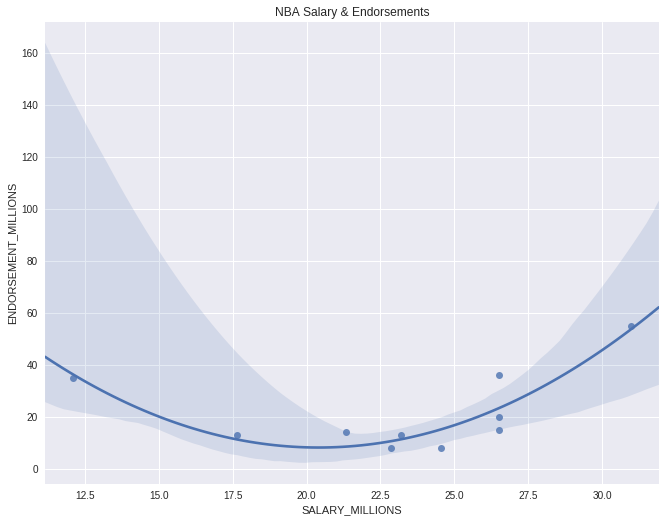

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
sns.regplot(data=df, 
            x="SALARY_MILLIONS", y="ENDORSEMENT_MILLIONS", 
            order=2).set_title("NBA Salary & Endorsements")

### Putting it all together (Production Style)

In [0]:
!pip -q install python-json-logger

In [0]:
import logging
from pythonjsonlogger import jsonlogger

LOG = logging.getLogger()
LOG.setLevel(logging.DEBUG)
logHandler = logging.StreamHandler()
formatter = jsonlogger.JsonFormatter()
logHandler.setFormatter(formatter)
LOG.addHandler(logHandler)

import click
import boto3
import pandas as pd

TEST_DF = pd.DataFrame(
    {"SentimentRaw": ["I am very Angry",
                    "We are very Happy",
                    "It is raining in Seattle"]}
)

def create_sentiment(row):
    """Uses AWS Comprehend to Create Sentiments on a DataFrame"""

    LOG.info(f"Processing {row}")
    comprehend = boto3.client(service_name='comprehend', region_name="us-east-1")
    payload = comprehend.detect_sentiment(Text=row, LanguageCode='en')
    LOG.debug(f"Found Sentiment: {payload}")    
    sentiment = payload['Sentiment']
    return sentiment

def apply_sentiment(df, column="SentimentRaw"):
    """Uses Pandas Apply to Create Sentiment Analysis"""

    df['Sentiment'] = df[column].apply(create_sentiment)
    return df

In [0]:
df = apply_sentiment(TEST_DF)

{"message": "Processing I am very Angry"}
{"message": "Processing I am very Angry"}
{"message": "Event choose-service-name: calling handler <function handle_service_name_alias at 0x7f8fb5845950>"}
{"message": "Event choose-service-name: calling handler <function handle_service_name_alias at 0x7f8fb5845950>"}
{"message": "Event creating-client-class.comprehend: calling handler <function add_generate_presigned_url at 0x7f8fb588f378>"}
{"message": "Event creating-client-class.comprehend: calling handler <function add_generate_presigned_url at 0x7f8fb588f378>"}
{"message": "The s3 config key is not a dictionary type, ignoring its value of: None"}
{"message": "The s3 config key is not a dictionary type, ignoring its value of: None"}
{"message": "Setting comprehend timeout as (60, 60)"}
{"message": "Setting comprehend timeout as (60, 60)"}
{"message": "Registering retry handlers for service: comprehend"}
{"message": "Registering retry handlers for service: comprehend"}
{"message": "Event bef

In [0]:
df.head()

SentimentRaw Sentiment
0           I am very Angry  NEGATIVE
1         We are very Happy  POSITIVE
2  It is raining in Seattle   NEUTRAL

## 7.5 Cloud9



*   Web based [development environment](https://docs.aws.amazon.com/cloud9/latest/user-guide/sample-python.html)


![Cloud9](https://user-images.githubusercontent.com/58792/50033517-afe14000-ffad-11e8-894a-f70389a046d7.png)



### [Demo]Cloud9



*   Create a cloud9 environment
*   Install Python 3.6

---



```bash
sudo yum -y update
sudo yum -y install python36

```







**Python Lambda Function**

```python
import json
import decimal


def lambda_handler(event, context):

  print(event)
  if 'body' in event:
    event = json.loads(event["body"])
  
  amount = float(event["amount"])
  res = []
  coins = [1,5,10,25]
  coin_lookup = {25: "quarters", 10: "dimes", 5: "nickels", 1: "pennies"}
  coin = coins.pop()
  num, rem  = divmod(int(amount*100), coin)
  res.append({num:coin_lookup[coin]})
  while rem > 0:
    coin = coins.pop()
    num, rem = divmod(rem, coin)
    if num:
      if coin in coin_lookup:
        res.append({num:coin_lookup[coin]})

  response = {
    "statusCode": "200",
    "headers": { "Content-type": "application/json" },
    "body": json.dumps({"res": res})
  }

  return response
```



**payload**



```javascript
{"amount": ".71"}
```



**response**



```javascript
Response
{
    "statusCode": "200",
    "headers": {
        "Content-type": "application/json"
    },
    "body": "{\"res\": [{\"2\": \"quarters\"}, {\"2\": \"dimes\"}, {\"1\": \"pennies\"}]}"
}

Function Logs
{'amount': '.71'}

Request ID
d7ec2cad-8da0-4394-957e-41f07bad23ae
```




## Reference Key Terminology

### Sagemaker Built-in Algorithms



#### BlazingText


* unsupervised learning algorithm for generating **Word2Vec embeddings.**
* aws blog post [BlazingText](https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-blazingtext-parallelizing-word2vec-on-multiple-cpus-or-gpus/)



![BlazingText](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/01/18/sagemaker-word2vec-3-1.gif)

#### DeepAR Forecasting

* supervised learning algorithm for forecasting scalar (that is, one-dimensional) time series using recurrent neural networks (RNN)
* [DeepAR Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)

![DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/images/deepar-2.png)